# 5주차 과제 - XAI

안녕하세요! 모두들 5주차 세션까지 오시느라 수고 많으셨습니다 😊  
이번 과제에서는 세션에서 소개한 대표적인 XAI 기법 중 **SHAP, Grad-CAM**을 간단히 구현해 보면서 각각의 특징과 활용 방법을 직접 살펴보겠습니다.




## 1번
먼저, 의료 데이터(Stroke Prediction Data)를 활용해 간단한 예측 모델을 만들고,  
**SHAP**을 이용해 **모델이 어떤 근거로 판단했는지** 직접 확인해보겠습니다.  

특히 SHAP은 의료 데이터 분석에서 **특정 환자의 예측 근거를 설명**할 때 자주 사용되는 기법입니다.  
먼저 뇌졸중 예측 데이터셋을 이용하여 모델을 만들고, global/local 설명을 출력해보도록 하겠습니다.

### 1) Import Library


In [ ]:
import os, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import shap
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED); random.seed(SEED)


### 2) Data Load
KaggleHub을 이용해 Stroke Prediction Dataset을 불러옵니다.  


In [ ]:
USE_KAGGLEHUB = True
df = None
import kagglehub
from kagglehub import KaggleDatasetAdapter
file_path = "healthcare-dataset-stroke-data.csv"
df = kagglehub.load_dataset(
      KaggleDatasetAdapter.PANDAS,
      "fedesoriano/stroke-prediction-dataset",
      file_path,
      )

print("데이터 크기:", df.shape)
df.head()


Using Colab cache for faster access to the 'stroke-prediction-dataset' dataset.
데이터 크기: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### 3) Data Preprocessing
- 불필요 컬럼(id) 제거  
- `gender`의 희귀값(Other)을 최빈값으로 대체  
- 수치형: 평균 대치 + 표준화  
- 범주형: 최빈 대치 + 원-핫 인코딩

가장 기본적이고 표준적인 전처리 방법을 적용했습니다. 더 정교한 처리가 필요하다고 생각되면 자유롭게 전처리를 추가해 보셔도 좋습니다 :)

In [ ]:
target_col = "stroke"
df = df.drop(columns=["id"], errors="ignore")

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

num_cols = X.select_dtypes(include=["int64","float64","int32","float32"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols)
])


### 4) Train/Test Split
불균형 데이터이므로 `stratify=y` 옵션을 사용해 클래스 분포를 유지하였습니다.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)


### 5) 모델 학습
세 가지 모델(RandomForestClassifier, XGBClassifier, LGBMClassifier)을 학습해보고  
AUROC, AUPRC 등 성능을 비교합니다.

마찬가지로 세 모델 이외의 다른 모델을 추가적으로 시도해보고 싶으신 분은 자유롭게 진행해주세요!

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = {
    "RF": RandomForestClassifier(
        n_estimators=300,
        random_state=SEED,
        class_weight="balanced_subsample",
        n_jobs=-1
    ),
    "XGB": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED,
        use_label_encoder=False,
        eval_metric="logloss"
    ),
    "LGBM": LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=SEED,
        class_weight="balanced"
    )
}


results = {}
for name, clf in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)

    pred_prob = pipe.predict_proba(X_test)[:,1]
    pred = (pred_prob >= 0.5).astype(int)
    auroc = roc_auc_score(y_test, pred_prob)
    aupr  = average_precision_score(y_test, pred_prob)
    print(f"\n=== {name} ===")
    print(f"AUROC={auroc:.3f}  AUPRC={aupr:.3f}")
    print(confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred, digits=3))
    results[name] = pipe



=== RF ===
AUROC=0.775  AUPRC=0.141
[[971   1]
 [ 50   0]]
              precision    recall  f1-score   support

           0      0.951     0.999     0.974       972
           1      0.000     0.000     0.000        50

    accuracy                          0.950      1022
   macro avg      0.476     0.499     0.487      1022
weighted avg      0.905     0.950     0.927      1022


=== XGB ===
AUROC=0.816  AUPRC=0.212
[[965   7]
 [ 45   5]]
              precision    recall  f1-score   support

           0      0.955     0.993     0.974       972
           1      0.417     0.100     0.161        50

    accuracy                          0.949      1022
   macro avg      0.686     0.546     0.568      1022
weighted avg      0.929     0.949     0.934      1022

[LightGBM] [Info] Number of positive: 199, number of negative: 3889
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_row_wise=true` to remove the overh

**Q1.** 세 가지 모델(또는 추가로 시도한 모델) 중 최종적으로 선택한 모델은 무엇인가요?
그리고 그 모델을 선택한 이유를 성능 지표나 해석 용이성 관점에서 설명해 주세요.

**A.**

### 6) SHAP 설명 대상 모델 선택
위 답변의 모델을 선택하여 진행합니다.

In [ ]:
model = results["LGBM"]  # 선택한 모델 이름을 적어주세요

In [ ]:
prep = model.named_steps["prep"]
feature_names = num_cols.copy()
if len(cat_cols) > 0:
    ohe = prep.named_transformers_["cat"].named_steps["ohe"]
    cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
    feature_names = num_cols + cat_feature_names


### 7) SHAP 값 계산
- 사용한 모델이 모두 트리 모델이기 때문에 `TreeExplainer` 사용합니다!
- 만약, 그 외 모델을 사용한 경우, `KernelExplainer`로 바꿔주세요


In [ ]:
X_train_tx = prep.transform(X_train)
X_test_tx  = prep.transform(X_test)

X_test_tx_df = pd.DataFrame(X_test_tx, columns=feature_names)

explainer = shap.TreeExplainer(model.named_steps["clf"])
shap_result = explainer(X_test_tx, check_additivity=False)
shap_for_pos = shap_result.values[:, :, 1] if shap_result.values.ndim == 3 else shap_result.values

### 9) SHAP 시각화
- **Summary Plot**: 전역적으로 어떤 피처가 중요한지  
- **Bar Plot**: 단순 중요도 막대  
- **Waterfall Plot**: 개별 샘플에 대한 국소 설명


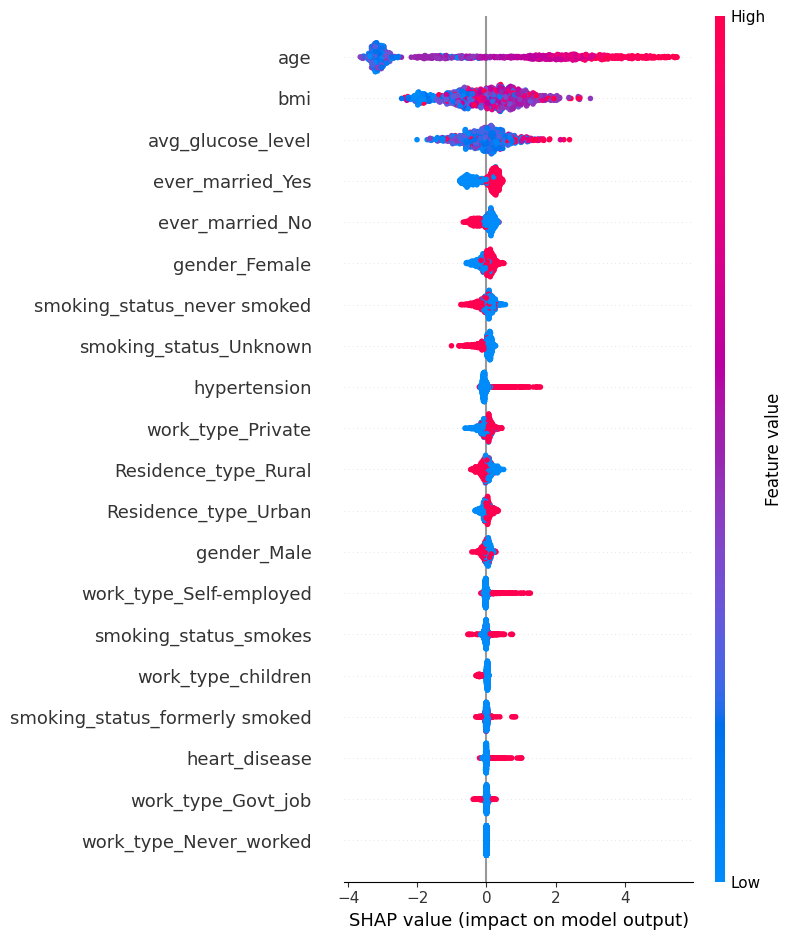

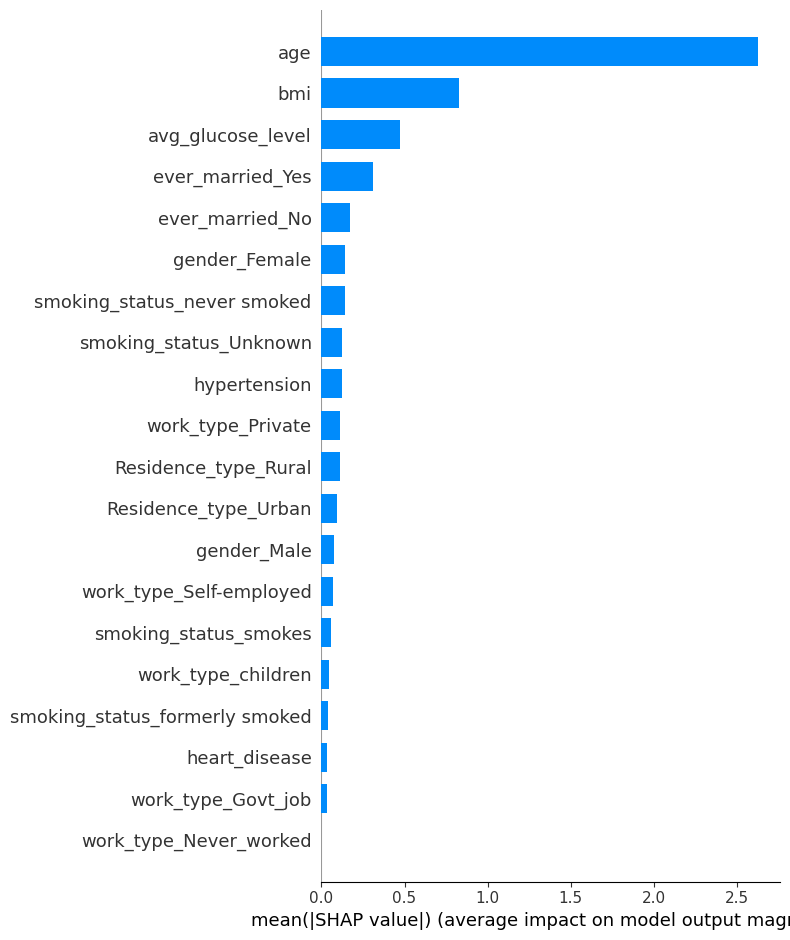

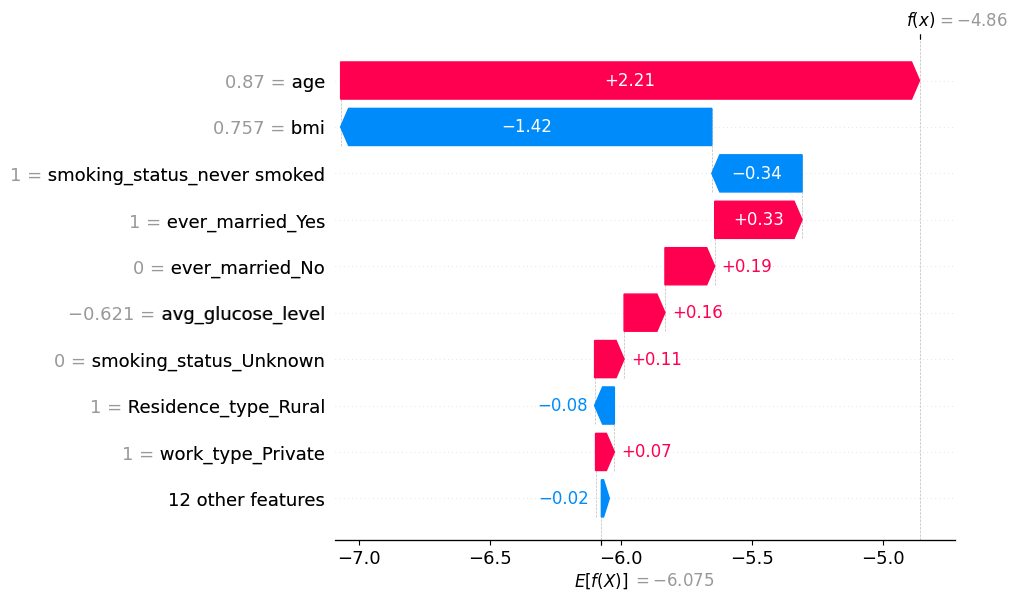

In [ ]:
X_shap = X_test_tx_df

shap.initjs()

# Summary plot
shap.summary_plot(shap_for_pos, X_shap, feature_names=feature_names)

# Bar plot
shap.summary_plot(shap_for_pos, X_shap, feature_names=feature_names, plot_type="bar")

# Waterfall
sample_i = 0
sv_row = shap_for_pos[sample_i]

expected_value = explainer.expected_value
if isinstance(expected_value, (list, np.ndarray)) and len(expected_value) > 1:
    expected_value = expected_value[1]

shap.plots.waterfall(
    shap.Explanation(
        values=sv_row,
        base_values=expected_value,
        feature_names=feature_names,
        data=X_shap.iloc[sample_i]
    )
)


**Q2.** Summary plot/bar plot 결과에 대하여, **상위 3개 피처**가 모델에 어떤 의미를 주는지 설명해주세요.  

**A**

## 2번

이번에는 이미지 데이터에 적용할 수 있는 대표적인 XAI 기법인 **Grad-CAM**을 활용해봅니다.  
Grad-CAM은 합성곱 신경망(CNN)의 마지막 Convolution Layer의 Gradient를 활용하여,  
모델이 어떤 부분을 보고 해당 클래스로 예측했는지 **시각적으로 설명**해주는 방법입니다.

### 0) 환경 준비
Grad-CAM 구현에 필요한 패키지들을 불러옵니다.  
- `ResNet50` : 사전 학습된 대표적인 CNN 모델  
- `image` : 이미지 불러오기 및 전처리에 활용  
- `matplotlib` : 이미지 시각화에 사용


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import resnet50, ResNet50
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### 1) 사전 학습된 모델 불러오기
`ImageNet` 데이터셋으로 학습된 **ResNet50** 모델을 불러옵니다.  
이 모델은 1,000개의 클래스를 분류할 수 있으며, 우리가 불러올 이미지를 어떤 클래스로 인식하는지도 확인할 수 있습니다.



In [ ]:
model = ResNet50(weights = 'imagenet')
model.summary()

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

model.summary()`를 실행하면 ResNet50의 전체 구조(레이어, 파라미터 수 등)를 확인할 수 있습니다.  
특히 Grad-CAM은 **마지막 Convolution Layer**를 활용하므로, 모델 구조를 이해하는 게 중요합니다.

### 2)  테스트 이미지 불러오기
이제 Grad-CAM을 적용할 테스트 이미지를 불러옵니다.  
저는 골든 리트리버 사진 파일을 다운받아 sample_data 폴더에 업로드하여 사용했으며, ResNet50의 입력 크기인 `(224,224)`로 리사이즈합니다.

다른 물체 사진을 다운받아 다양하게 시도해보세요!



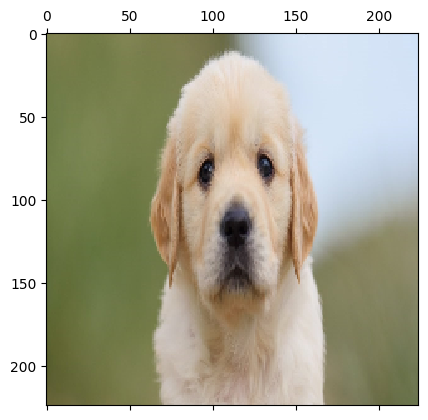

In [ ]:
image_path='___________' # 사진 경로로 수정해주세요!
img = image.load_img(image_path, target_size=(224,224))
plt.matshow(img)

### 3) 이미지 전처리 & 예측 결과 확인
ResNet50 모델에 이미지를 넣기 전에 입력 형태에 맞게 전처리합니다.  
- `img_to_array` : 이미지를 숫자 배열로 변환  
- `expand_dims` : 배치 차원 추가 (모델 입력은 `(배치, 높이, 너비, 채널)` 형태)  
- `preprocess_input` : ResNet50 학습 시 사용된 방식대로 정규화  

마지막으로 `predict`를 통해 모델의 예측 결과를 확인합니다.


In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = resnet50.preprocess_input(x)

preds=model.predict(x)
print("예측 결과:", resnet50.decode_predictions(preds,top=5)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
예측 결과: [('n02099601', 'golden_retriever', np.float32(0.6214738)), ('n02111500', 'Great_Pyrenees', np.float32(0.15452985)), ('n02099712', 'Labrador_retriever', np.float32(0.0897076)), ('n02108551', 'Tibetan_mastiff', np.float32(0.050888404)), ('n02101556', 'clumber', np.float32(0.024379693))]


출력된 결과는 모델이 인식한 Top-5 클래스와 확률입니다.  
예를 들어 `Labrador retriever` 또는 `Golden retriever` 의 클래스로 높은 확률로 예측된 것을 확인할 수 있습니다!


### 4) Grad-CAM Heatmap 생성
이제 Grad-CAM을 구현해봅니다. 핵심 아이디어는 다음과 같습니다:
1. 마지막 Convolution Layer의 출력을 가져오기 (`conv5_block3_out`)  
2. 이 출력에 대해 관심 있는 클래스(class_id)의 Gradient를 계산  
3. 채널별 Gradient 평균값(`pooled_grads`)을 Feature Map에 가중치로 곱해줌  
4. 채널별 결과를 합쳐 Heatmap 생성  

즉, "이 클래스 예측에 가장 중요한 영역"을 시각적으로 표현하게 됩니다.


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_40']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


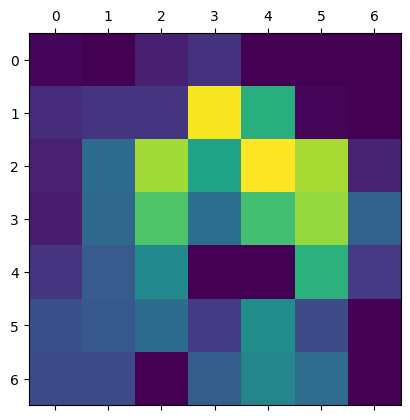

In [ ]:
last_conv_layer=model.get_layer("conv5_block3_out")

model_1 = keras.Model(model.inputs,last_conv_layer.output)

input_2 = keras.Input(shape = last_conv_layer.output.shape[1:])
x_2=model.get_layer("avg_pool")(input_2)
x_2=model.get_layer("predictions")(x_2)
model_2=keras.Model(input_2,x_2)

with tf.GradientTape() as tape:
  output_1=model_1(x)
  tape.watch(output_1)
  preds=model_2(output_1)
  class_id=tf.argmax(preds[0])
  output_2=preds[:,class_id]

grads = tape.gradient(output_2,output_1)
pooled_grads = tf.reduce_mean(grads,axis=(0,1,2))

output_1 = output_1.numpy()[0]
pooled_grads=pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
  output_1[:,:,i]*=pooled_grads[i]
heatmap=np.mean(output_1,axis=-1)

heatmap=np.maximum(heatmap,0)/np.max(heatmap)
plt.matshow(heatmap)

위 결과로 출력된 Heatmap은 모델이 어떤 영역을 집중적으로 보았는지를 나타냅니다.  
아직은 원본 이미지와 분리된 형태라서 "강아지의 몸통" 또는 "얼굴" 같은 부위를 직접적으로 확인하긴 어렵습니다.


### 5) Heatmap을 원본 이미지에 Overlay
마지막으로 Heatmap을 원본 이미지 위에 겹쳐서 시각화합니다.  
- `jet colormap`을 이용해 Heatmap에 색상을 입힘  
- 원본 이미지 크기에 맞게 Resize  
- Overlay 후 결과 시각화

/tmp/ipython-input-394506418.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet=cm.get_cmap("jet")


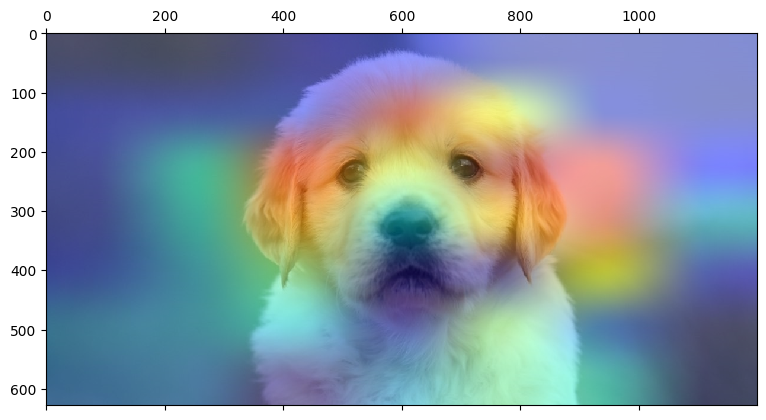

In [ ]:
img=image.load_img(image_path)

img=image.img_to_array(img)
heatmap=np.uint8(255*heatmap)

jet=cm.get_cmap("jet")
color=jet(np.arange(256))[:,:3]
color_heatmap = color[heatmap]

color_heatmap = keras.preprocessing.image.array_to_img(color_heatmap)
color_heatmap = color_heatmap.resize((img.shape[1],img.shape[0]))
color_heatmap = keras.preprocessing.image.img_to_array(color_heatmap)

overlay_img=color_heatmap*0.7+img
overlay_img=keras.preprocessing.image.array_to_img(overlay_img)
plt.matshow(overlay_img)

이를 통해 **모델이 실제로 강아지의 어느 부위를 보고 '강아지'라고 인식했는지** 직관적으로 확인할 수 있습니다!

**Q3** 본인의 Grad-CAM 결과를 보고, 예측에 집중한 이미지 영역이 직관적으로 맞는지 설명해주세요

**A.**